In [1]:
import numpy as np
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM

2023-08-15 00:00:13.983483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DATA_TRAIN_PATH = tf.keras.utils.get_file(
    'ratings_train.txt',
    'https://github.com/ironmanciti/NLP_lecture/raw/master/data/naver_movie/ratings_train.txt'
)
DATA_TEST_PATH = tf.keras.utils.get_file(
    'ratings_test.txt',
    'https://github.com/ironmanciti/NLP_lecture/raw/master/data/naver_movie/ratings_test.txt'
)

In [3]:
train_data = pd.read_csv(DATA_TRAIN_PATH, delimiter='\t')
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [4]:
test_data = pd.read_csv(DATA_TEST_PATH, delimiter='\t')
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [5]:
train_data = train_data.sample(n=50000, random_state=42)
test_data = train_data.sample(n=5000, random_state=42)
train_data.shape, test_data.shape

((50000, 3), (5000, 3))

In [6]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [7]:
train_data.isnull().sum(), test_data.isnull().sum()

(id          0
 document    0
 label       0
 dtype: int64,
 id          0
 document    0
 label       0
 dtype: int64)

In [9]:
okt = Okt()
test_text = '아버지가방에들어가신다'
okt.morphs(test_text, stem=True)

['아버지', '가방', '에', '들어가신다']

In [10]:
def preprocessing(sentence, remove_stopwords=True):
    #stop_words = set(['에', '은', '는', '이', '가', '그리고', '것', '들', '수', '등', '로', '을', '를', '만', '도', '아', '의', '그', '다'])
    stop_words = []
    sentence = re.sub('\\\\n', ' ', sentence)
    sentence = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ ]', '', sentence)
    sentence = okt.morphs(sentence, stem=True)
    if remove_stopwords:
        sentence = [token for token in sentence if token not in stop_words]
    return sentence

In [14]:
%%time
train_sentences = []
train_labels = []
test_sentences = []
test_labels = []
for i, (sentence, label) in enumerate(zip(train_data['document'], train_data['label'])):
    if i % 10000 == 0:
        print(f'Train processed = {i}')
    sentence = preprocessing(sentence)
    if len(sentence) > 0:
        train_sentences.append(sentence)
        train_labels.append(label)
for i, (sentence, label) in enumerate(zip(test_data['document'], test_data['label'])):
    if i % 1000 == 0:
        print(f'Test processed = {i}')
    sentence = preprocessing(sentence)
    if len(sentence) > 0:
        test_sentences.append(sentence)
        test_labels.append(label)


Train processed = 0
Train processed = 10000
Train processed = 20000
Train processed = 30000
Train processed = 40000
Test processed = 0
Test processed = 1000
Test processed = 2000
Test processed = 3000
Test processed = 4000
CPU times: user 3min 7s, sys: 1.38 s, total: 3min 8s
Wall time: 3min 4s


In [16]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
train_labels.shape, test_labels.shape

((49552,), (4956,))

In [17]:
VOCAB_SIZE = 20_000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
train_sequences[0], test_sequences[0]

([11051, 7, 95, 4], [2, 51, 43, 4728, 1, 2337, 276, 3, 2235])

(array([5.9700e+03, 6.8590e+03, 1.0896e+04, 5.9100e+03, 5.1260e+03,
        6.0040e+03, 2.6960e+03, 1.8910e+03, 1.7550e+03, 8.3300e+02,
        1.0050e+03, 6.0300e+02, 5.3500e+02, 7.0200e+02, 4.4200e+02,
        4.1100e+02, 4.8700e+02, 3.4700e+02, 3.1800e+02, 4.9700e+02,
        3.6300e+02, 4.4900e+02, 1.6800e+02, 1.2500e+02, 7.8000e+01,
        2.0000e+01, 7.0000e+00, 5.0000e+00, 4.0000e+00, 2.0000e+00]),
 array([ 1.        ,  3.36666667,  5.73333333,  8.1       , 10.46666667,
        12.83333333, 15.2       , 17.56666667, 19.93333333, 22.3       ,
        24.66666667, 27.03333333, 29.4       , 31.76666667, 34.13333333,
        36.5       , 38.86666667, 41.23333333, 43.6       , 45.96666667,
        48.33333333, 50.7       , 53.06666667, 55.43333333, 57.8       ,
        60.16666667, 62.53333333, 64.9       , 67.26666667, 69.63333333,
        72.        ]),
 <BarContainer object of 30 artists>)

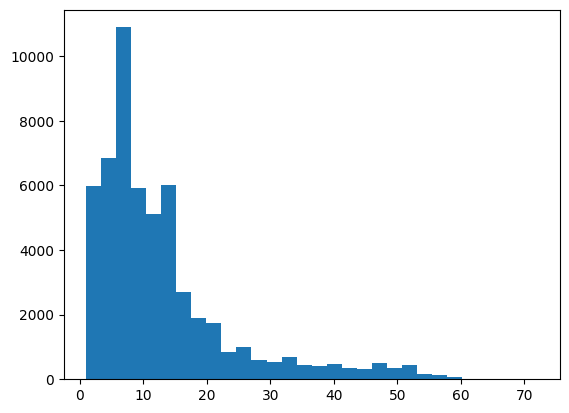

In [15]:
plt.hist([len(seq) for seq in train_sequences] + [len(seq) for seq in test_sequences], bins=30)

In [18]:
max_length = 15
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_padded.shape, test_padded.shape

((49552, 15), (4956, 15))

In [24]:
train_padded[4], test_padded[4]

(array([1410,  147, 1087,   10,   58,  606,    7,  756,    7, 2954,   11,
        1071,  786,  571,  444], dtype=int32),
 array([4550, 1263,  423,   69,  102,   12, 2308,  383,   12,   41, 1998,
          50,   13,    4, 1614], dtype=int32))

In [25]:
def decode_sentence(sequence):
    return ' '.join([tokenizer.index_word.get(i, '?') for i in sequence])

In [26]:
print(decode_sentence(train_padded[4]))
print(train_sentences[4])

우와 별 반개 도 아깝다 판 에 밑 에 알바생 들 쩐다 전부 만점 이야
['우와', '별', '반개', '도', '아깝다', '판', '에', '밑', '에', '알바생', '들', '쩐다', '전부', '만점', '이야', 'ㅎㅎㅎ', '야', '그만하다', '저', '영화', '는', '정말', '쓰레기', '다', '원작', '에서', '크게', '벋다', '나다', '마치', '메간폭스', '를', '위해', '스폰', '한', '영화', '저걸', '보다', '투니버스', '보다', '돈', '아깝다', '시간', '아깝다']


In [27]:
model = Sequential([
    Embedding(VOCAB_SIZE + 1, 64),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2023-08-15 00:24:05.799822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6638 MB memory:  -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:3f:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280064   
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1350273 (5.15 MB)
Trainable params: 1350273 (5.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
num_epochs = 30
history = model.fit(
    train_padded, 
    train_labels, 
    epochs=num_epochs, 
    batch_size=128,
    validation_data=(test_padded, test_labels),
    verbose=1
)

Epoch 1/30


2023-08-15 00:25:31.813061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-15 00:25:32.014184: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff5100180b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-15 00:25:32.014267: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-08-15 00:25:32.027678: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-15 00:25:32.205588: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/388 [==============================] - 43s 91ms/step - loss: 0.4558 - accuracy: 0.7765 - val_loss: 0.3236 - val_accuracy: 0.8658
Epoch 2/30
388/388 [==============================] - 9s 23ms/step - loss: 0.3297 - accuracy: 0.8558 - val_loss: 0.2584 - val_accuracy: 0.8973
Epoch 3/30
388/388 [==============================] - 8s 22ms/step - loss: 0.2664 - accuracy: 0.8851 - val_loss: 0.2023 - val_accuracy: 0.9171
Epoch 4/30
388/388 [==============================] - 7s 19ms/step - loss: 0.2169 - accuracy: 0.9074 - val_loss: 0.1679 - val_accuracy: 0.9366
Epoch 5/30
388/388 [==============================] - 7s 18ms/step - loss: 0.1802 - accuracy: 0.9239 - val_loss: 0.1394 - val_accuracy: 0.9483
Epoch 6/30
388/388 [==============================] - 7s 17ms/step - loss: 0.1510 - accuracy: 0.9373 - val_loss: 0.1180 - val_accuracy: 0.9566
Epoch 7/30
388/388 [==============================] - 5s 12ms/step - loss: 0.1305 - accuracy: 0.9467 - val_loss: 0.1146 - val_accuracy: 0.9562
Epoch 8/3

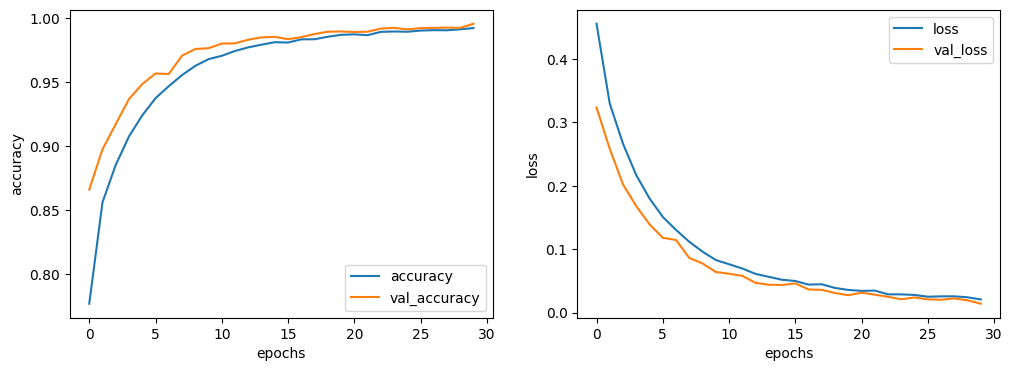

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.legend()
ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()

In [30]:
test_data

,id,document,label
75865,7690899,이게 그 블레이드 런너 흉내 낸 영화구나,0
132934,9686380,너무 잼났어여 ㅎㅎ 편안하게 보세요,1
41258,8062785,이 영화 보면서 진짜 짜증이 밀려오는데 스토리가 중요한 내용은 하나도 없고..여자아...,0
79037,7699472,인생을살면서 거짓말이 필요할때도있다,1
141357,3241706,윤아언니 ♡해요~!!저는 매일 너는 내 운명 드라마를 보는 학생이에요,1
...,...,...,...
71545,8113008,잘짜여진듯 하지만 오류투성인 영화,0
125741,6005993,재미있게 봤어요...>__신고,1
114398,3943161,솔직히 너무하네요 영화도 아직나오도 안햇는데 뭘봣다고 평점이 만땅이죠?,0
119912,3866103,볼땐 몰랐는데.... 그 잔상이 계속 남는다.,1


In [40]:
sample_text = ['정말 짜증나서 못 보겠다']
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post', truncating='post')
sample_padded

array([[21,  1, 49,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int32)

In [41]:
model.predict([sample_padded])

1/1 [==============================] - 0s 41ms/step


array([[0.22573298]], dtype=float32)

In [42]:
sample_text = ['오랜만에 접한 수작']
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post', truncating='post')
sample_padded

array([[  1,   1, 369,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int32)

In [43]:
model.predict([sample_padded])

1/1 [==============================] - 0s 29ms/step


array([[0.9839458]], dtype=float32)

In [44]:
['positive' if model.predict([sample_padded]) >= 0.5 else 'negative']

1/1 [==============================] - 0s 27ms/step


['positive']

In [45]:
model.layers

In [46]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(20001, 64)


In [47]:
out_v = open('data/vects.tsv', 'w', encoding='utf-8')
out_m = open('data/meta.tsv', 'w', encoding='utf-8')
for i in range(1, 1000):
    word = tokenizer.index_word.get(i, '?')
    embeddings = weights[i]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_v.close()
out_m.close()